# TITLE

# Introduction

blah blah blah blah

# Methods

**Loading Libraries**

In [1]:
library(tidyverse)
library(tidymodels)
library(digest)
library(repr)
library(infer)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Uploading Data and Tidying**

In [2]:
# the data was retreived from: 
data_link <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
data <- read_delim(data_link, ',', col_names = FALSE)

head(data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [3]:
# renaming the columns to their variable titles
colnames(data)[1] <- "age"
colnames(data)[2] <- "sex"
colnames(data)[3] <- "chest_pain_type"
colnames(data)[4] <- "resting_bp"
colnames(data)[5] <- "cholestrol"
colnames(data)[6] <- "fasting_blood_sugar"
colnames(data)[7] <- "rest_ecg"
colnames(data)[8] <- "max_heart_rate"
colnames(data)[9] <- "exercise_angina"
colnames(data)[14] <- "hd_diagnosis"

# selecting variables that are of interest to our investigation
data <- select(data, 
                     age,
                     sex,
                     chest_pain_type,
                     resting_bp,
                     cholestrol,
                     fasting_blood_sugar, 
                     rest_ecg,
                     max_heart_rate,
                     exercise_angina,
                     hd_diagnosis)

head(data)

age,sex,chest_pain_type,resting_bp,cholestrol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,hd_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,0
67,1,4,160,286,0,2,108,1,2
67,1,4,120,229,0,2,129,1,1
37,1,3,130,250,0,0,187,0,0
41,0,2,130,204,0,2,172,0,0
56,1,2,120,236,0,0,178,0,0


**Set Seed (will not be changed nor shown after this)**

In [4]:
set.seed(2000) ### DO NOT CHANGE!

**Split our dataset to Training and Testing data**

In [5]:
cleveland_split <- initial_split(data, prop=0.75, stata=resting_bp)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)
cleveland_split

<Training/Testing/Total>
<227/76/303>

In [6]:
#checking for null/na data in the training data
paste("Number of null values:", sum(map_df(cleveland_training, is.null)))
paste("Number of N/A values:", sum(map_df(cleveland_training, is.na)))

[1] "Number of null values: 0"

[1] "Number of N/A values: 0"

**Initial Assessment**

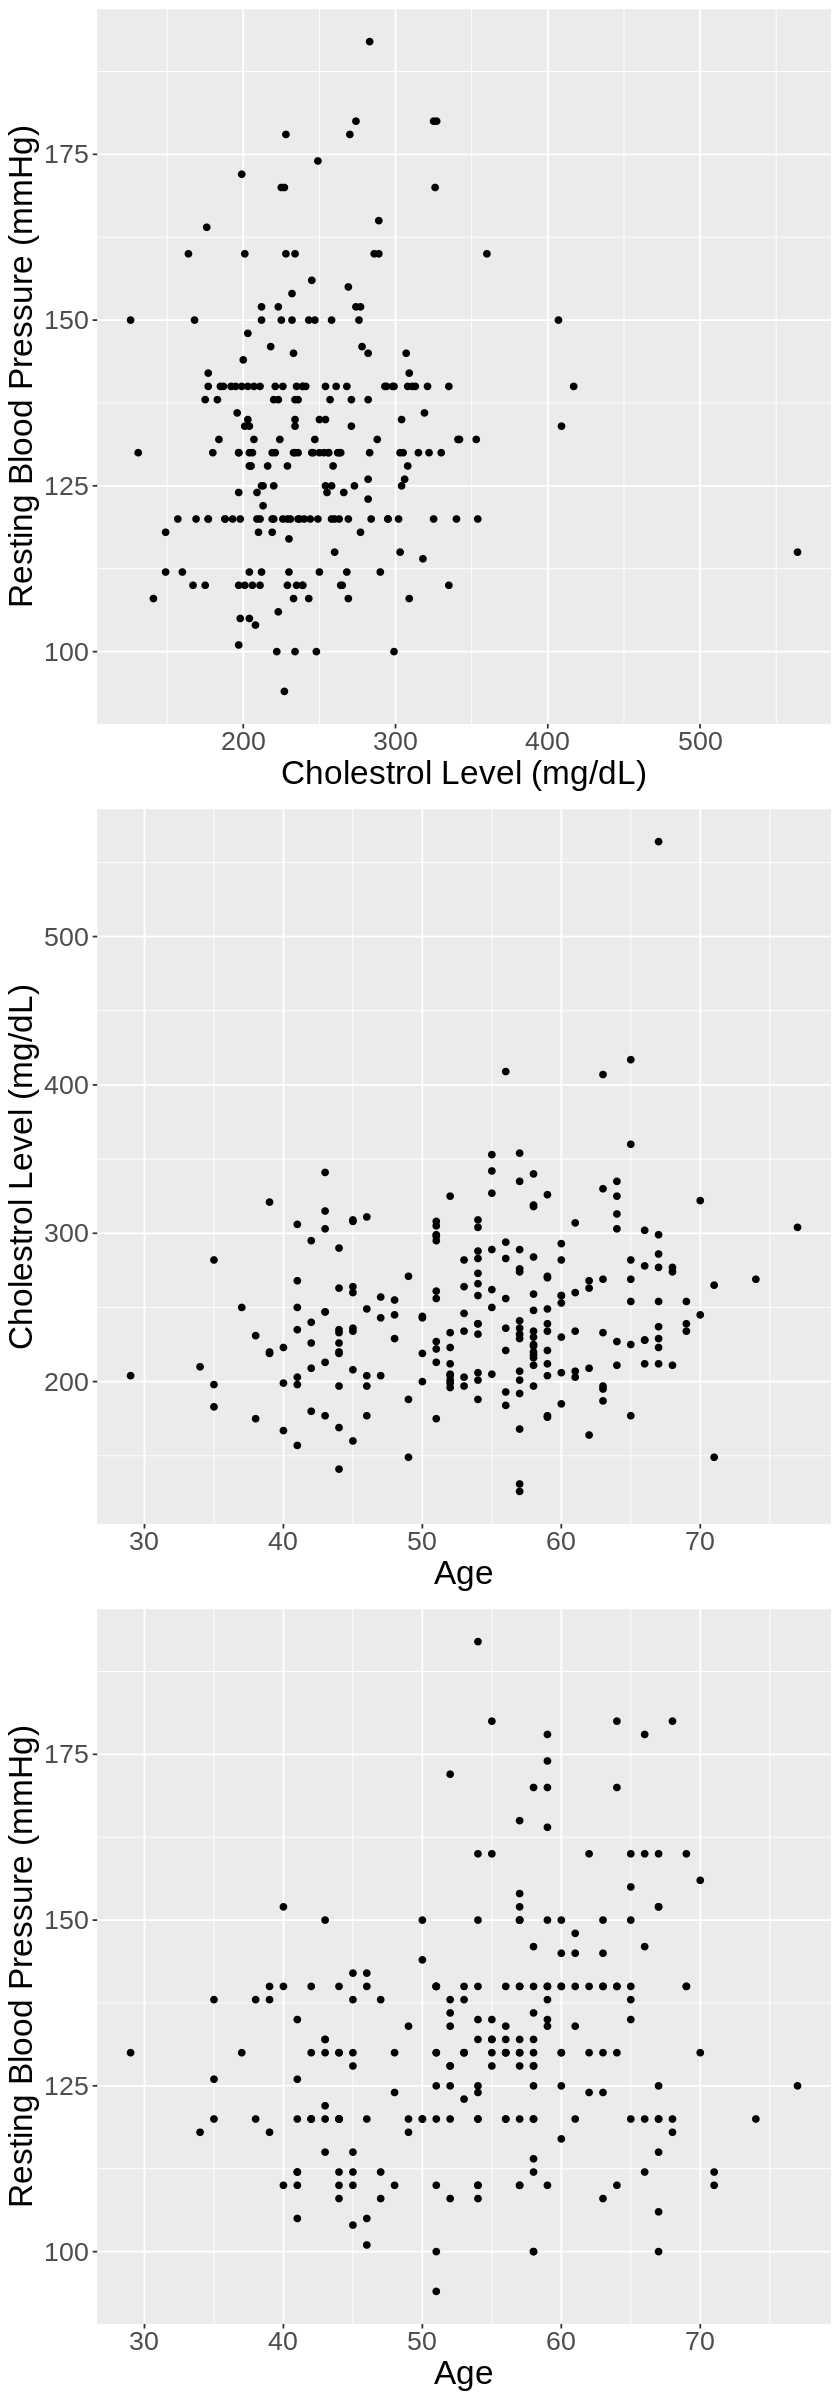

In [7]:
options(repr.plot.width = 7, repr.plot.height = 20)

heart <- tibble()

chol_rbp_plot <- cleveland_training |>
    ggplot(aes(x=cholestrol, y=resting_bp)) +
    geom_point() +
    labs(x="Cholestrol Level (mg/dL)", y="Resting Blood Pressure (mmHg)") + 
    theme(text = element_text(size=20))


chol_age_plot <- cleveland_training |>
    ggplot(aes(x = age, y = cholestrol)) +
    geom_point() +
    labs(x = "Age", y = "Cholestrol Level (mg/dL)") + 
    theme(text = element_text(size=20))


age_rbp_plot <- cleveland_training |>
    ggplot(aes(x = age, y = resting_bp)) +
    geom_point() +
    labs(x = "Age", y = "Resting Blood Pressure (mmHg)") + 
    theme(text = element_text(size=20))


initial_plots <- plot_grid(chol_rbp_plot, chol_age_plot, age_rbp_plot, ncol = 1)
initial_plots

Initial analysis and assessment here

**Model Specification**

In [8]:
# Creating model specification for k-nn
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                       set_engine("kknn") |>
                       set_mode("regression")
heart_spec

#Preprocessing the data 
heart_recipe <- recipe(resting_bp ~ cholestrol + age, data = cleveland_training) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) |>
                        prep()
heart_recipe

# Inspecting the preprocessing steps
scaled_heart <- bake(heart_recipe, cleveland_training)

head(scaled_heart)

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Training data contained 227 data points and no missing data.

Operations:

Scaling for cholestrol, age [trained]
Centering for cholestrol, age [trained]

cholestrol,age,resting_bp
<dbl>,<dbl>,<dbl>
1.4371897,-0.2537332,120
-1.1366762,0.1893240,132
-1.4470005,-1.5829050,110
0.7982868,-1.1398477,112
-0.8628607,-0.2537332,172
-0.2239578,1.6292601,160


comment

**Cross-Validation of Training Data with 5 folds**

In [9]:
# 5 fold cross validation
heart_vfold <- vfold_cv(cleveland_training, v = 5, strata = resting_bp)


# Combining model specification and recipe
heart_workflow <- workflow() |>
                        add_recipe(heart_recipe) |>
                        add_model(heart_spec)

heart_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


comment

**Tuning the Workflow**

In [30]:
#Creating a tibble of number of neighbors
gridvalues <- tibble(neighbors = seq(from = 1, to = 150))

heart_results <-heart_workflow |>
  tune_grid(resamples =heart_vfold, grid = gridvalues) |>
  collect_metrics() |>
  filter(.metric == "rmse")

head(heart_results)


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,22.85661,5,1.2454229,Preprocessor1_Model001
2,rmse,standard,20.26165,5,0.9356235,Preprocessor1_Model002
3,rmse,standard,18.84313,5,0.6965354,Preprocessor1_Model003
4,rmse,standard,18.38105,5,0.5477692,Preprocessor1_Model004
5,rmse,standard,17.95976,5,0.4807513,Preprocessor1_Model005
6,rmse,standard,17.58085,5,0.5175398,Preprocessor1_Model006


comment

**Determining the Minimum RMSPE**

In [31]:
#CODE HERE

heart_min <- heart_results |>
            filter(mean == min(mean)) |>
            slice(1)

heart_min

heart_k <- heart_min |>
             pull(neighbors)

heart_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
61,rmse,standard,16.90899,5,0.391118,Preprocessor1_Model061


[1] 61

comment

**Evaluating on our Testing Dataset**

In [33]:
#Creating new spec with minimum k
heart_spec2 <- nearest_neighbor(weight_func = "rectangular", 
                                neighbors = heart_k) |>
                  set_engine("kknn") |>
                  set_mode("regression")

knn_mult_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_spec2) |>
  fit(data = cleveland_training)

knn_mult_preds <- knn_mult_fit |>
  predict(cleveland_testing) |>
  bind_cols(cleveland_testing)

knn_mult_mets <- metrics(knn_mult_preds, truth = resting_bp, estimate = .pred) |>
                     filter(.metric == 'rmse')

knn_mult_mets

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,16.62258


comment

# Results

In [15]:
#CODE HERE (plot our final graph?) 

In [16]:
results briefly explained

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected symbol
1: results briefly
            ^


# Discussion

explanation